<a href="https://colab.research.google.com/github/sameershinde14/ToxicCommentsChallengeKaggle/blob/master/XGBoost_with_Processed_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pickle_util import load_pickles
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from matplotlib import pyplot as plt

In [0]:
x_classes = ["comment_text"]
y_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_threat"]

In [0]:
(
    train_x,
    valid_x,
    test_x,
    train_y,
    valid_y,
    test_y
) = load_pickles()

In [0]:
word_vectorizer = TfidfVectorizer(lowercase=False,ngram_range=(1,3),max_features=20000)
word_vectorizer = word_vectorizer.fit(train_x["comment_text"])
train_features = word_vectorizer.transform(train_x["comment_text"])
validation_features = word_vectorizer.transform(valid_x["comment_text"])
test_features = word_vectorizer.transform(test_x["comment_text"])

In [0]:
import xgboost as xgb


def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=2017, num_rounds=500, depth=6):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.1
    param['max_depth'] = depth
    param['silent'] = 1
    param['eval_metric'] = 'auc'
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    result = {}
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, evals_result = result, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds, evals_result = result )

    return model, result  

In [41]:
import numpy as np
import gc
col = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
#col = ['toxic']
preds = np.zeros((test_x.shape[0], len(col)))
res = {}

max_depths = [10, 20, 40, 80]
train_mean_aucs, val_mean_aucs = [], []

for max_depth in max_depths:
  for i, j in enumerate(col):
      val_aucs = []
      train_aucs = []
      print('fit '+j)
      model, res = runXGB(train_features, train_y[j], validation_features,valid_y[j],max_depth)
      train_aucs.append(res['train']['auc'][-1])
      val_aucs.append(res['test']['auc'][-1])
      preds[:,i] = model.predict(xgb.DMatrix(test_features), ntree_limit = model.best_ntree_limit)
      gc.collect()
  val_mean_aucs.append(np.mean(val_aucs))
  train_mean_aucs.append(np.mean(train_aucs))

fit toxic


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-auc:0.625685	test-auc:0.616597
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[1]	train-auc:0.731297	test-auc:0.718169
[2]	train-auc:0.740991	test-auc:0.725486
[3]	train-auc:0.741861	test-auc:0.72581
[4]	train-auc:0.750587	test-auc:0.737132
[5]	train-auc:0.751146	test-auc:0.738137
[6]	train-auc:0.755215	test-auc:0.742356
[7]	train-auc:0.761158	test-auc:0.747719
[8]	train-auc:0.761546	test-auc:0.748025
[9]	train-auc:0.775094	test-auc:0.760426
[10]	train-auc:0.775803	test-auc:0.761681
[11]	train-auc:0.817286	test-auc:0.803108
[12]	train-auc:0.819961	test-auc:0.806595
[13]	train-auc:0.822419	test-auc:0.808703
[14]	train-auc:0.826043	test-auc:0.811501
[15]	train-auc:0.826111	test-auc:0.812141
[16]	train-auc:0.846341	test-auc:0.828533
[17]	train-auc:0.846462	test-auc:0.82893
[18]	train-auc:0.851031	test-auc:0.832537
[19]	train-auc:0.851133	test-auc:0.833431
[20]	train-auc:0.863812	test-au

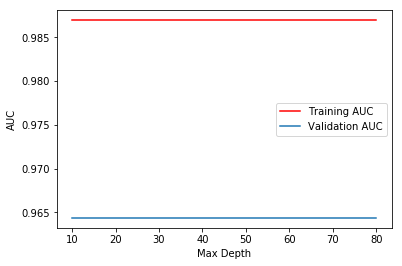

In [42]:
plt.plot(max_depths, train_mean_aucs, "r", label="Training AUC")
plt.plot(max_depths, val_mean_aucs, label="Validation AUC")
plt.xlabel("Max Depth")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [44]:
train_mean_aucs

[0.98693, 0.98693, 0.98693, 0.98693]

In [45]:
train_mean_aucs_2, val_mean_aucs_2 = [], []

for max_depth in max_depths:
  model, res = runXGB(train_features, train_y, validation_features,valid_y,max_depth)
  train_mean_aucs_2.append(res['train']['auc'][-20])
  val_mean_aucs_2.append(res['test']['auc'][-20])
  preds[:,i] = model.predict(xgb.DMatrix(test_features), ntree_limit = model.best_ntree_limit)
  gc.collect()
  

ValueError: ignored

In [0]:
subm = pd.read_csv('./sample_submission.csv')    
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = col)], axis=1)
submission.to_csv('xgb.csv', index=False)